In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/sample_submission.csv
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/train.csv
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_c03579cc.jpg
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_b3d33ea0.jpg
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_b3e23b3a.jpg
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_0c4444af.jpg
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_1a8d037f.jpg
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_c8bdcd57.jpg
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_8ac1d777.jpg
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_2790518b.jpg
/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/test/test_8c03fc9b.jpg
/kaggle/input/dlp-image-classification-for-han

In [2]:
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [3]:
BASE_DIR = Path("/kaggle/input/dlp-image-classification-for-handwriting/downlaod1/")
TRAIN_DIR = BASE_DIR / "train"
TEST_DIR = BASE_DIR / "test"
TRAIN_CSV = BASE_DIR / "train.csv"
SAMPLE_SUB = BASE_DIR / "sample_submission.csv"

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything()


In [4]:
train_df = pd.read_csv(TRAIN_CSV)

print(train_df.head())
print(train_df.label.value_counts())


          image_id  label
0    digit_0_0.jpg      0
1    digit_0_1.jpg      0
2   digit_0_10.jpg      0
3  digit_0_100.jpg      0
4  digit_0_101.jpg      0
label
0    93
1    93
2    93
3    93
4    93
5    93
6    93
7    93
8    93
9    93
Name: count, dtype: int64


In [5]:
train_df.tail()

,image_id,label
925,digit_9_59.jpg,9
926,digit_9_6.jpg,9
927,digit_9_60.jpg,9
928,digit_9_61.jpg,9
929,digit_9_62.jpg,9


In [6]:
train_df.shape

(930, 2)

In [7]:
train_df.columns.tolist()

['image_id', 'label']

In [8]:
train_df.label.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [9]:
train_df.groupby('label')

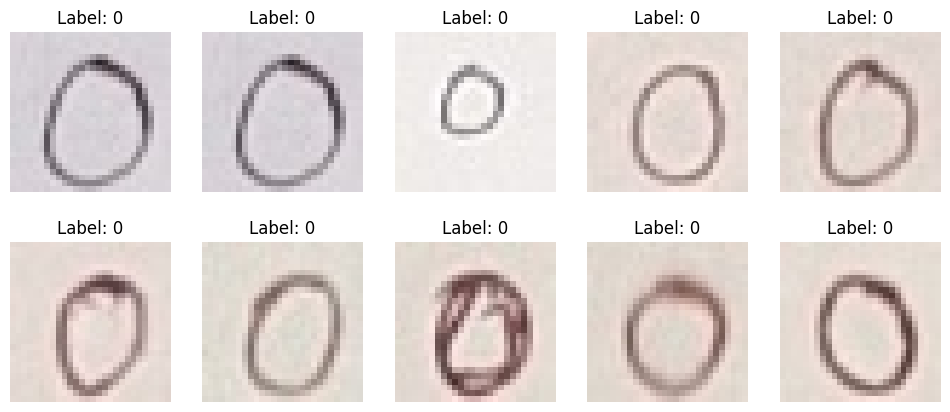

In [10]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i, ax in enumerate(axes.flatten()):
    row = train_df.iloc[i]
    img = Image.open(TRAIN_DIR / row.image_id)
    ax.imshow(img)
    ax.set_title(f"Label: {row.label}")
    ax.axis("off")

plt.show()


In [11]:
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df.label,
    random_state=42
)


In [12]:
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [13]:
class DigitDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.img_dir / self.df.loc[idx, "image_id"]
        image = Image.open(img_path).convert("L")
        label = self.df.loc[idx, "label"]

        if self.transform:
            image = self.transform(image)

        return image, label


In [14]:
train_dataset = DigitDataset(train_df, TRAIN_DIR, train_transforms)
val_dataset = DigitDataset(val_df, TRAIN_DIR, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, 10)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 191MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="max",
    factor=0.5,
    patience=2
)


In [17]:
def train_one_epoch(model, loader):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [18]:
def validate(model, loader):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds.extend(torch.argmax(outputs, 1).cpu().numpy())
            targets.extend(labels.numpy())

    acc = accuracy_score(targets, preds)
    return acc


In [19]:
number=9

In [20]:
best_acc = 0

for epoch in range(number):
    train_loss = train_one_epoch(model, train_loader)
    val_acc = validate(model, val_loader)

    scheduler.step(val_acc)

    print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")


Epoch 1: Loss=0.5493, Val Acc=0.8548
Epoch 2: Loss=0.1064, Val Acc=0.8226
Epoch 3: Loss=0.0879, Val Acc=0.9839
Epoch 4: Loss=0.0380, Val Acc=0.9892
Epoch 5: Loss=0.0753, Val Acc=0.9839
Epoch 6: Loss=0.0831, Val Acc=0.9731
Epoch 7: Loss=0.0611, Val Acc=0.9892
Epoch 8: Loss=0.0235, Val Acc=0.9892
Epoch 9: Loss=0.0190, Val Acc=0.9946


In [21]:
test_df = pd.read_csv(SAMPLE_SUB)

test_dataset = DigitDataset(
    test_df.assign(label=0),
    TEST_DIR,
    val_transforms
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load("best_model.pth"))
model.eval()

predictions = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1)
        predictions.extend(preds.cpu().numpy())

test_df["label"] = predictions
test_df.to_csv("/kaggle/working/submission.csv", index=False)


In [22]:
import os
print(os.path.exists("submission.csv"))
print(os.getcwd())
print(os.listdir("."))

True
/kaggle/working
['best_model.pth', '__notebook__.ipynb', 'submission.csv']


In [23]:
try:
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    test_df["label"] = predictions
    test_df.to_csv("submission.csv", index=False)
    print(f"Saved {len(predictions)} predictions to submission.csv")
except Exception as e:
    print(f"Error: {e}")

Saved 400 predictions to submission.csv
